In [5]:
import sys
import os
from os import path
from datetime import date
import math
import warnings
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from plotnine import *
from scipy import stats
from scipy.stats import linregress
import gspread
from mizani.formatters import scientific_format
from mizani.breaks import date_breaks
from mizani.formatters import date_format
import warnings

%matplotlib inline

import skmisc
import outliers
from outliers import smirnov_grubbs as grubbs

# read in custom modules
sys.path.append('/Users/rosekantor/work/wbe_data_analysis/')

from read_gsheets import * 
from reprocess_qpcr import *
from calculations import *
from qa_qc import *
from quality_score import *

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

# Data tables:

In [19]:
sites = '/Users/rosekantor/scientific_work/Nelson_lab/wbe_project/data_wbe/site_lookup_120820.csv'
samples = '/Users/rosekantor/scientific_work/Nelson_lab/wbe_project/data_wbe/sample_inventory_120820.csv'
qpcr = '/Users/rosekantor/scientific_work/Nelson_lab/wbe_project/data_wbe/QuantStudio_raw_data_120820.csv'
plates = '/Users/rosekantor/scientific_work/Nelson_lab/wbe_project/data_wbe/Plate_info_120820.csv'

In [20]:
pd.read_csv(sites).head()

,utility_name,county,utility,facility,interceptor,sample_code,sample_level,sampling_days,sampling_frequency_per_week,interceptor_full_name,interceptor_description,interceptor_start_date,interceptor_pretreatment,interceptor_region_served,interceptor_population_served,interceptor_general_flow_MGD
0,SD5,Marin,A,A,INF,A_A_INF,Influent,Tuesday,1.0,Sanitary District No.5 of Marin County,NaN,NaN,NaN,NaN,NaN,NaN
1,CMSA,Marin,B,B,RV,B_B_RV,Influent,Tuesday,1.0,Ross Valley,NaN,NaN,NaN,NaN,NaN,NaN
2,CMSA,Marin,B,B,SD2,B_B_SD2,Influent,Tuesday,1.0,Sanitation district 2,NaN,NaN,NaN,NaN,NaN,NaN
3,CMSA,Marin,B,B,SQ,B_B_SQ,Residential,"Saturday,Sunday,Monday,Tuesday",4.0,San Quentin Prison,NaN,NaN,NaN,NaN,NaN,NaN
4,CMSA,Marin,B,B,SR,B_B_SR,Influent,Tuesday,1.0,San Rafael,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
pd.read_csv(samples)[1000:1010]

,new_sample_id,sample_id,batch,sample_code,date_sampling,replicate,date_extract,extracted_by,weight,bCoV_spike_tube,GFP_spike_tube,processing_error,qPCR_batch,Storage_conditions,salted_before_freezing,date_frozen,elution_vol_ul,effective_vol_extracted_ml,weight_vol_extracted_ml,bCoV_spike_vol_ul,GFP_spike_vol_ul,time,storage_notes
1000,D_SEP_CH_101520_2,D_SEP_CH_101520_2,R101620_1,D_SEP_CH,10/15/2020,2,10/16/2020,NaN,63.485,CN,BR,NaN,NaN,NaN,1.0,NaN,200.0,40.0,40.0,50.0,20.0,NaN,NaN
1001,D_SEP_CH_101520_3,D_SEP_CH_101520_3,R101620_1,D_SEP_CH,10/15/2020,3,10/16/2020,NaN,63.485,CN,BR,NaN,NaN,NaN,1.0,NaN,200.0,40.0,40.0,50.0,20.0,NaN,NaN
1002,D_SEP_CH_101520_4,D_SEP_CH_101520_4,NaN,D_SEP_CH,10/15/2020,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-80,1.0,10/15/20,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1003,D_SEP_Frank_101520_1,D_SEP_Frank_101520_1,R101620_1,D_SEP_Frank,10/15/2020,1,10/16/2020,NaN,63.485,CN,BR,NaN,R17,NaN,1.0,NaN,200.0,40.0,40.0,50.0,20.0,NaN,NaN
1004,D_SEP_Frank_101520_2,D_SEP_Frank_101520_2,R101620_1,D_SEP_Frank,10/15/2020,2,10/16/2020,NaN,63.485,CN,BR,NaN,NaN,NaN,1.0,NaN,200.0,40.0,40.0,50.0,20.0,NaN,NaN
1005,D_SEP_Frank_101520_3,D_SEP_Frank_101520_3,R101620_1,D_SEP_Frank,10/15/2020,3,10/16/2020,NaN,63.485,CN,BR,NaN,NaN,NaN,1.0,NaN,200.0,40.0,40.0,50.0,20.0,NaN,NaN
1006,D_SEP_Frank_101520_4,D_SEP_Frank_101520_4,NaN,D_SEP_Frank,10/15/2020,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-80,1.0,10/15/20,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1007,D_SEP_Friedman_101520_1,D_SEP_Friedman_101520_1,R101620_1,D_SEP_Friedman,10/15/2020,1,10/16/2020,NaN,63.485,CN,BR,NaN,R17,NaN,1.0,NaN,200.0,40.0,40.0,50.0,20.0,NaN,NaN
1008,D_SEP_Friedman_101520_2,D_SEP_Friedman_101520_2,R101620_1,D_SEP_Friedman,10/15/2020,2,10/16/2020,NaN,63.485,CN,BR,NaN,NaN,NaN,1.0,NaN,200.0,40.0,40.0,50.0,20.0,NaN,NaN
1009,D_SEP_Friedman_101520_3,D_SEP_Friedman_101520_3,R101620_1,D_SEP_Friedman,10/15/2020,3,10/16/2020,NaN,63.485,CN,BR,NaN,NaN,NaN,1.0,NaN,200.0,40.0,40.0,50.0,20.0,NaN,NaN


In [22]:
pd.read_csv(qpcr).tail()

,Well,Omit,Sample,Target,Dye,Task,Cq,Quantity,well_id,plate_id,is_primary_value,is_dilution,inhibition_testing
19015,H5,FALSE,1X_M_M_INF_120620_2,PMMoV Ultra man,FAM,Unknown,25.6048177,50253.1524,1121_H5,1121,Y,Y,N
19016,H6,FALSE,1X_M_M_INF_120620_2,PMMoV Ultra man,FAM,Unknown,25.6157637,49886.3476,1121_H6,1121,Y,Y,N
19017,H7,FALSE,5X_M_M_INF_120620_2,PMMoV Ultra man,FAM,Unknown,27.3969783,15144.2220,1121_H7,1121,Y,Y,N
19018,H8,FALSE,5X_M_M_INF_120620_2,PMMoV Ultra man,FAM,Unknown,27.1804003,17506.4619,1121_H8,1121,Y,Y,N
19019,H9,FALSE,5X_M_M_INF_120620_2,PMMoV Ultra man,FAM,Unknown,27.346284,15666.8605,1121_H9,1121,Y,Y,N


In [23]:
pd.read_csv(plates).tail()

,plate_id,plate_file_name,added pop up lab samples,plate_date,assays,standard_batch,description,run_by,rxn_volume,template_volume,plate_notes
197,1117,1117_PMMoV_Routine12.05,R62,12/05/20,PMMoV,DNA1.1,Routine samples processed 12/05,Justin,20.0,5.0,NaN
198,1118,1118_bCoV_11.30-12.04,R63,12/07/20,bCoV,DNA1.1,Routine samples week of 11/30,Melissa,20.0,5.0,NaN
199,1119,1119_GFP_11.30-12.04,R63,12/07/20,GFP,1.1,Routine samples week of 11/30,Melissa,20.0,5.0,NaN
200,1120,1120_N1_Routine12.08,R64,12/8/20,N1,DNA1.1,Routine samples processed 12/08,Melissa,20.0,5.0,NaN
201,1121,1121_PMMoV_Routine12.08,R64,12/8/20,PMMoV,DNA1.1,Routine samples processed 12/08,Melissa,20.0,5.0,NaN


# Run processing pipeline

In [24]:
# define defaults
gc = None # reading from CSV so no google authentication
url = None # reading from CSV so no url
rxn_volume = 20.0
template_volume = 5.0

plate_df = read_qpcr_data(gc, url, qpcr)
plate_df = plate_df[plate_df.plate_id >= 1000] # until dataset is cleaned, we must remove old plates

qpcr_processed_dilutions, plate_target_info = process_qpcr_plate(plate_df)

# merge plate data with data coming from process_qpcr_plate
plate_info_df = pd.read_csv(plates)
plate_target_info = plate_target_info.merge(plate_info_df, how = 'left', on = 'plate_id')

# fill in default values
plate_target_info.loc[plate_target_info.rxn_volume.isna(), 'rxn_volume'] = rxn_volume
plate_target_info.loc[plate_target_info.template_volume.isna(), 'template_volume'] = template_volume

# process Xeno assay results to check for inhibition, note that we are no longer using Xeno, but old data still contains it
qpcr_processed_dilutions_xeno = qpcr_processed_dilutions[qpcr_processed_dilutions.Target == 'Xeno']
df_xeno = []
for plate_id, df in qpcr_processed_dilutions_xeno.groupby('plate_id'):
    df_inhibition = process_xeno_inhibition(df, plate_target_info, plate_id)
    df_xeno.append(df_inhibition)
df_xeno = pd.concat(df_xeno)
qpcr_processed_dilutions = qpcr_processed_dilutions.merge(df_xeno, how='left', on=['Sample', 'dilution', 'plate_id'])
qpcr_processed_dilutions = qpcr_processed_dilutions[qpcr_processed_dilutions.Target != 'Xeno']

# process dilutions (we do 1x and 5x dilutions for each sample, so we need to choose one to report)
qpcr_processed = choose_dilution(qpcr_processed_dilutions)

# merge with sample data and plate_target info
# merging is dangerous, extra rows can be introduced if the merge isn't exact (e.g. multiple identical entries- see warnings)
sample_data = read_sample_data(gc, url, samples, sites)
sample_data_qpcr = qpcr_processed.merge(sample_data, how = 'left', left_on = 'Sample', right_on = 'sample_id')
sample_data_qpcr = sample_data_qpcr.merge(plate_target_info, how = 'left', on = ['plate_id', 'Target'])

# pull out extraction controls and report them for each batch
sample_data_qpcr = get_extraction_control(sample_data_qpcr)

# add quality scores
quality_scores = quality_score(sample_data_qpcr)
sample_data_qpcr = sample_data_qpcr.merge(quality_scores, how='left', on=['Sample', 'Target', 'plate_id'])

# calculate gc/L and N1:PMMoV
sample_data_qpcr['gc_per_L'] = calculate_gc_per_l(sample_data_qpcr)
sample_data_qpcr.loc[sample_data_qpcr.gc_per_L.isna(), 'gc_per_L'] = 0 # convert values to zero
sample_data_qpcr = normalize_to_pmmov(sample_data_qpcr)
sample_data_qpcr.loc[sample_data_qpcr.mean_normalized_to_pmmov.isna(), 'mean_normalized_to_pmmov'] = 0 # convert values to zero

# filter out controls and samples without a county
sample_data_qpcr = sample_data_qpcr[~sample_data_qpcr.county.isna()].copy()
sample_data_qpcr = sample_data_qpcr[~sample_data_qpcr.county.str.contains('control')].copy() # these filters can't be in the same line or pandas freaks

# make column listing number of technical replicates detected, based on the non-detect count
sample_data_qpcr['detected_of_3_TechReps'] = 3 - sample_data_qpcr['nondetect_count']

/Users/rosekantor/work/wbe_data_analysis/reprocess_qpcr.py:304: UserWarning: Plate 1064 is missing NTC
/Users/rosekantor/work/wbe_data_analysis/reprocess_qpcr.py:304: UserWarning: Plate 1064 is missing NTC
/Users/rosekantor/work/wbe_data_analysis/reprocess_qpcr.py:415: UserWarning: Sample B_B_SQ_110720_2 x N1 has multiple entries with the same dilution factor in plates [1064, 1064, 1070]
/Users/rosekantor/work/wbe_data_analysis/reprocess_qpcr.py:415: UserWarning: Sample D_SEP_NF_101520_1 x N1 has multiple entries with the same dilution factor in plates [1033, 1052]
/Users/rosekantor/work/wbe_data_analysis/reprocess_qpcr.py:415: UserWarning: Sample D_SEP_NF_101520_2 x N1 has multiple entries with the same dilution factor in plates [1051, 1052]
/Users/rosekantor/work/wbe_data_analysis/reprocess_qpcr.py:415: UserWarning: Sample D_SEP_NF_101520_3 x N1 has multiple entries with the same dilution factor in plates [1051, 1052]
/Users/rosekantor/work/wbe_data_analysis/reprocess_qpcr.py:415: Us

In [25]:
sample_data_qpcr.head()

,Sample,dilution,Task,Cq,Quantity,is_undetermined,Cq_no_outliers,Cq_init_mean,Cq_init_std,Cq_init_min,replicate_init_count,Q_init_mean,Q_init_std,Cq_mean,Cq_std,replicate_count,nondetect_count,Quantity_mean,below_limit_of_quantification,plate_id,Target,xeno_dCt,is_inhibited,Quantity_mean_undiluted,new_sample_id,sample_id,batch,sample_code,date_sampling,replicate,date_extract,extracted_by,weight,bCoV_spike_tube,GFP_spike_tube,processing_error,qPCR_batch,Storage_conditions,salted_before_freezing,date_frozen,elution_vol_ul,effective_vol_extracted_ml,weight_vol_extracted_ml,bCoV_spike_vol_ul,GFP_spike_vol_ul,time,storage_notes,utility_name,county,utility,facility,interceptor,sample_level,sampling_days,sampling_frequency_per_week,interceptor_full_name,interceptor_description,interceptor_start_date,interceptor_pretreatment,interceptor_region_served,interceptor_population_served,interceptor_general_flow_MGD,num_points,slope,intercept,r2,efficiency,loq_Cq,loq_Quantity,Cq_of_lowest_std_quantity,used_default_curve,intraassay_var,Cq_of_lowest_sample_quantity,ntc_is_neg,ntc_Cq,plate_file_name,added pop up lab samples,plate_date,assays,standard_batch,description,run_by,rxn_volume,template_volume,plate_notes,extraction_control_is_neg,extraction_control_Cq,score,flag,point_deduction,quality_score,gc_per_ul_input,gc_per_L,pmmov_mean,mean_normalized_to_pmmov,log10mean_normalized_to_log10pmmov,log10_mean_normalized_to_pmmov,detected_of_3_TechReps
0,J_UCV_082020_1,1,Unknown,"[26.400205800000002, 26.5121506, 26.5770239]","[185899.78, 173442.458, 166609.032]","[False, False, False]","[26.400205800000002, 26.5121506, 26.5770239]",26.496460,0.073033,26.400206,3,1.751369e+05,1.056987,26.496460,0.073033,3,0,1.673479e+05,False,1001,PMMoV,NaN,NaN,1.673479e+05,J_J_UCV_082020_1,J_UCV_082020_1,R08212001,J_J_UCV,2020-08-20,1,2020-08-21,NaN,63.485,N,NaN,NaN,"R2, R4",-80,1.0,8/21/20,200.0,40.0,40.000,50.0,20.0,NaN,NaN,UCB,Alameda,J,J,UCV,Residential,Thursday,3.0,University Village,University Village,NaN,NaN,NaN,NaN,NaN,7,-3.702956,45.839298,0.998855,0.862321,38.141236,100.0,38.141236,False,15.630451,30.240900,False,39.36129,R1_PMMoV_Test,Batch R1,9/18/20,PMMoV,NaN,Melissa's first plate,Melissa,20.0,5.0,previously called R1,None,NaN,0.66,test for inhibition has not been performed; check extraction negative control,no-template qPCR control had low-level amplification,84.615385,3.346958e+04,1.673479e+08,167347.891598,1.000000,1.000000,0.000000,3
1,B_SQ_082520_1,1,Unknown,"[13.183179999999998, 13.20534, 13.17878]","[191000000.0, 188000000.0, 191000000.0]","[False, False, False]","[13.183179999999998, 13.17878]",13.189100,0.011623,13.178780,3,1.899947e+08,1.009182,13.180980,0.002200,2,0,1.796845e+08,False,1004,GFP,NaN,NaN,1.796845e+08,B_B_SQ_082520_1,B_SQ_082520_1,R09032001,B_B_SQ,2020-08-25,1,2020-09-03,NaN,63.890,AC,I,NaN,"R2, R4",-80,1.0,9/3/20,200.0,40.0,40.405,50.0,20.0,23:45,left out over weekend,CMSA,Marin,B,B,SQ,Residential,"Saturday,Sunday,Monday,Tuesday",4.0,San Quentin Prison,NaN,NaN,NaN,NaN,NaN,NaN,7,-3.487499,41.968574,0.999880,0.935256,27.919310,10000.0,27.919310,False,5.195485,13.733743,True,NaN,R4_GFP_Routine9.22,some of batch R2 + spikes,9/22/20,GFP,NaN,Adrian training plate,Adrian,20.0,5.0,previously called R4,None,NaN,0.55,test for inhibition has not been performed; check extraction negative control,num tech reps = 2; hold time > 5 days,70.512821,3.593690e+07,1.778834e+11,162166.703623,1108.023436,1.584371,3.044549,3
2,D_OSP_090120_1,1,Unknown,"[12.34061, 12.391810000000001, 12.40912]","[334000000.0, 323000000.0, 319000000.0]","[False, False, False]","[12.34061, 12.391810000000001, 12.40912]",12.380513,0.029087,12.340610,3,3.252719e+08,1.024048,12.380513,0.029087,3,0,3.048142e+08,False,1004,GFP,NaN,NaN,3.048142e+08,D_OSP_INF_090120_1,D_OSP_090120_1,R09032001,D_OSP_INF,2020-09-01,1,2020-09-03,NaN,64.510,AC,I,NaN,"R2, R4",-80,1.0,9/1/20,200.0,40.0,41.025,50.0,20.0,NaN,NaN,SFPUC,SF,D,OSP,INF,Influent,Tuesday,NaN,Oceanside Treatment Plant Influent,O

In [26]:
plate_target_info.tail()

,plate_id,Target,num_points,slope,intercept,r2,efficiency,loq_Cq,loq_Quantity,Cq_of_lowest_std_quantity,used_default_curve,intraassay_var,Cq_of_lowest_sample_quantity,ntc_is_neg,ntc_Cq,plate_file_name,added pop up lab samples,plate_date,assays,standard_batch,description,run_by,rxn_volume,template_volume,plate_notes
160,1117,PMMoV,6,-3.207499,44.904943,0.999875,1.050073,35.189785,1000.0,35.189785,False,5.277317,31.416045,True,NaN,1117_PMMoV_Routine12.05,R62,12/05/20,PMMoV,DNA1.1,Routine samples processed 12/05,Justin,20.0,5.0,NaN
161,1118,bCoV,7,-3.656714,42.510028,0.999869,0.877023,35.267820,100.0,35.267820,False,20.377761,31.946179,True,NaN,1118_bCoV_11.30-12.04,R63,12/07/20,bCoV,DNA1.1,Routine samples week of 11/30,Melissa,20.0,5.0,NaN
162,1119,GFP,7,-3.578420,42.531435,0.999731,0.903062,35.519453,100.0,35.519453,False,1080.935061,24.058116,True,NaN,1119_GFP_11.30-12.04,R63,12/07/20,GFP,1.1,Routine samples week of 11/30,Melissa,20.0,5.0,NaN
163,1120,N1,6,-3.638180,37.691217,0.995612,0.883054,34.574163,5.0,34.574163,False,30.361490,36.450813,True,NaN,1120_N1_Routine12.08,R64,12/8/20,N1,DNA1.1,Routine samples processed 12/08,Melissa,20.0,5.0,NaN
164,1121,PMMoV,7,-3.420844,41.624020,0.999872,0.960313,34.724517,100.0,34.724517,False,4.812941,29.778711,True,NaN,1121_PMMoV_Routine12.08,R64,12/8/20,PMMoV,DNA1.1,Routine samples processed 12/08,Melissa,20.0,5.0,NaN


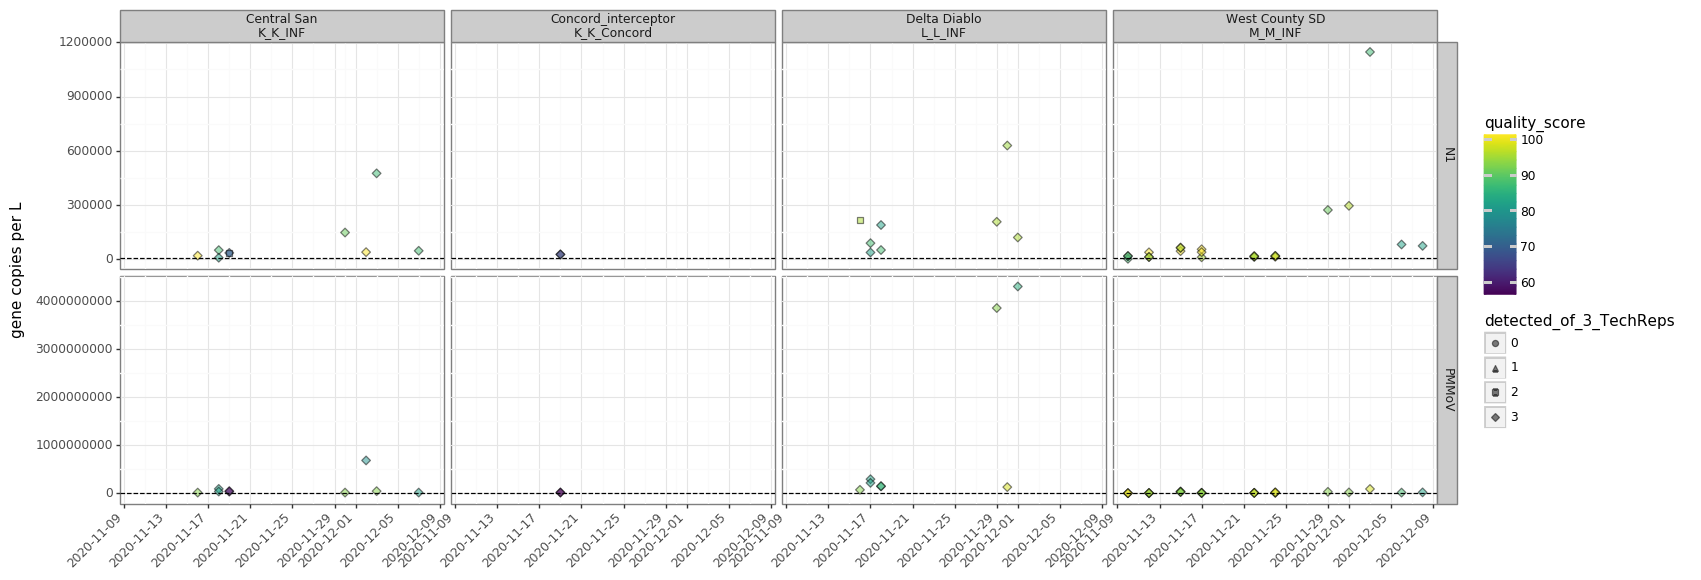

<ggplot: (304462565)>

In [28]:
# define all county dataframes
df_plotting = sample_data_qpcr[sample_data_qpcr.Target.isin(['N1', 'PMMoV'])].copy()
df_plotting.nondetect_count = df_plotting.nondetect_count.astype('category') # convert to category so we can plot them by shape
df_plotting.detected_of_3_TechReps = df_plotting.detected_of_3_TechReps.astype('category') # convert to category so we can plot them by shape

contracosta = df_plotting[df_plotting.county == 'Contra Costa'].copy()

# N1 and PMMoV
plt = (ggplot(contracosta, aes(x='date_sampling', y='gc_per_L', fill='quality_score', shape='detected_of_3_TechReps')) + 
geom_point(size=2, alpha=0.5)+
geom_abline(slope=0, intercept=10000, linetype='dashed')+
ylab('gene copies per L\n\n')+
xlab("")+
facet_grid('Target ~ interceptor_full_name + sample_code', scales='free_y')+ #, 
theme_bw()+ theme(axis_text_x=element_text(rotation=45, hjust=1), figure_size=(17,6)) )

display(plt)